In [1]:
%load_ext autoreload
%autoreload 2

import src.multiagent_mpc as mpc
import src.traffic_world as tw
import src.car_plotting_multiple as cmplot
import glob
import argparse
import json
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.offsetbox as offsetbox
import gc

In [75]:
class Args:
    def __init__(self):
        self.i = 0
args = Args()
args.end_mpc = -1
args.camera_speed = -1
args.shape = "ellipse"
args.svo_colors = 1
args.n_workers = 8
args.fps = 16
log_directory = "/home/nbuckman/mpc_results/svo_10_21/e015/"

In [4]:
with open(log_directory + "params.json",'rb') as fp:
    params = json.load(fp)
# filename = concat_imgs(args.folder) 
print("Loading data...")
if args.end_mpc == -1:
    # Find the last run.  We currently assumes that all runs start from 0 and increment by 1
    list_of_mpc_data = glob.glob(log_directory + 'data/all_*xamb.npy')
    n_mpc_runs = len(list_of_mpc_data)
    data_filename = log_directory + 'data/all_%03d'%(n_mpc_runs - 1)
    if os.path.isfile(data_filename + "xamb.npy"):
        pass
    else:
        data_filename = log_directory + 'data/all_%02d'%(n_mpc_runs - 1)
    print(data_filename)
else:
    n_mpc_runs = (args.end_mpc + 1)
    data_filename = log_directory + 'data/all_%03d'%args.end_mpc
    if os.path.isfile(data_filename +"xamb.npy"):
        pass
    else:
        data_filename = log_directory + 'data/all_%02d'%args.end_mpc
start_frame = 0
end_frame = (n_mpc_runs + 1) * params['number_ctrl_pts_executed'] - 1 #Not exactly sure why we need minus 1

xamb_actual, _, _, xothers_actual, _, _, = mpc.load_state(data_filename, params['n_other'], ignore_des=True)
response_vehicle = pickle.load(open(log_directory + "data/" + "mpcamb.p",'rb'))
if os.path.isfile(log_directory + "data/mpcother%03d.p"%0):
    other_vehicles = [pickle.load(open(log_directory + "data/mpcother%03d.p"%i,'rb')) for i in range(params["n_other"])]
elif os.path.isfile(log_directory + "data/mpcother%02d.p"%0):
    other_vehicles = [pickle.load(open(log_directory + "data/mpcother%02d.p"%i,'rb')) for i in range(params["n_other"])]
else:
    other_vehicles = [pickle.load(open(log_directory + "data/mpcother%d.p"%i,'rb')) for i in range(params["n_other"])]
world = tw.TrafficWorld(params["n_lanes"], 0, 999999) 

Loading data...
/home/nbuckman/mpc_results/svo_10_21/e015/data/all_037


In [5]:
# Prep the image directory
os.makedirs(log_directory+"imgs2/", exist_ok=True)    
filelist = glob.glob(os.path.join(log_directory+"imgs2/", "*.png"))
for f in filelist:
    os.remove(f)


In [6]:
# For when we would return a large vector that included datapoints defaulted to zero
if xamb_actual.shape[1] > end_frame:
    xamb_actual = xamb_actual[:, :end_frame]
    xothers_actual = [x[:, :end_frame] for x in xothers_actual]

print("Saving photos to %s..."%(log_directory+"imgs2/"))
if args.camera_speed == -1:
    camera_speed = np.mean(xamb_actual[4,:])
else:
    camera_speed = args.camera_speed
if args.svo_colors == 1:
    svo = []
    for veh in other_vehicles:
        if hasattr(veh, "theta_ij"):
            svo += [veh.theta_ij[-1]]
        else:
            svo += [veh.theta_iamb]
    car_colors = ['r' for i in range(len(svo))]
    for i in range(len(svo)):
        if svo[i] < np.pi/8.0:
            car_colors[i] = 'red'
        elif np.pi/8 <= svo[i] <= 3*np.pi/8.0:
            car_colors[i] = 'purple'
        elif np.pi/8 <= svo[i] <= np.pi/2.0:
            car_colors[i] = 'blue'
else:
    car_colors = None
# if args.image:
#     cmplot.plot_cars(world, response_vehicle, xamb_actual[:,start_frame:end_frame], [x[:,start_frame:end_frame] for x in xothers_actual], log_directory, "image", True, camera_speed)              
# else:

Saving photos to /home/nbuckman/mpc_results/svo_10_21/e015/imgs2/...


In [7]:
dummy_camera_positions = list(range(600))
dummy_camera_positions[220] = 580

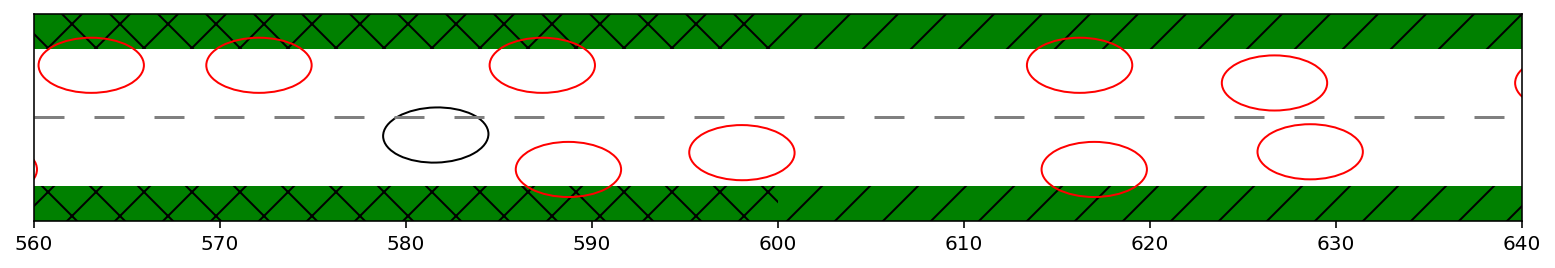

In [9]:
f, a = cmplot.plot_multiple_cars(220, world, response_vehicle, xamb_actual[:,start_frame:end_frame], [x[:,start_frame:end_frame] for x in xothers_actual], None, args.shape, dummy_camera_positions, None, car_colors)


In [66]:
x_dist = np.array([(x[0,start_frame] - xamb_actual[0, start_frame])for x in xothers_actual])
idxs_plot = np.argsort(x_dist)
idxs_plot = [i for i in idxs_plot if x_dist[i]>=-.5]
idxs_plot = idxs_plot[:3]
start_frame = 220
end_frame = 250

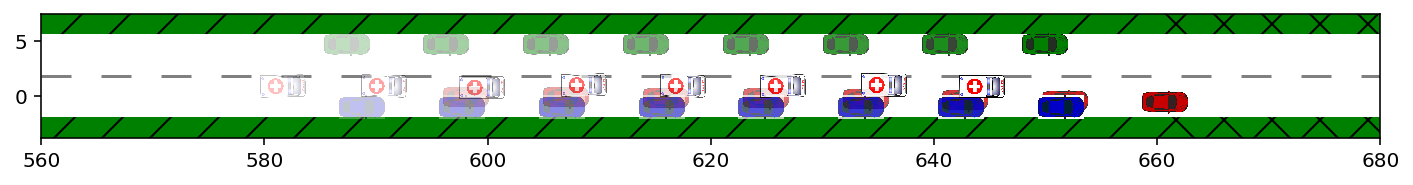

In [67]:
cmplot.plot_single_frame(world, response_vehicle, xamb_actual[:, start_frame:end_frame:4], [xothers_actual[i][:,start_frame:end_frame:4] for i in range(len(xothers_actual)) if i in idxs_plot], None, "image", None, None, None,  None, [560, 680])

In [74]:
x_mpc = response_vehicle
xamb_plot = xamb_actual[:, start_frame:end_frame:14]
xothers_plot = [xothers_actual[i][:,start_frame:end_frame:14] for i in range(len(xothers_actual)) if i in idxs_plot]
folder = None
car_plot_shape="Image"
parallelize=True
camera_speed = None
plot_range = None
car_ids = None
xlims = [575, 680]
colors_sub = [car_colors[i] for i in idxs_plot]
folder = log_directory
'''Plots the progression of all cars in one frame'''
if camera_speed is None:
    camera_speed = x_mpc.max_v
figsize="LARGE"
if figsize == "LARGE":
    figwidth_in=12.0
else:
    figwidth_in=6.0
ymax = world.y_max
ymin = world.y_min     
# initial_speed = 0.9 * x_mpc.max_v
# center_frame = xamb_plot[0,k]

k = 0
center_frame = xamb_plot[0,0] + k*camera_speed*x_mpc.dt
# center_frame = xamb_plot[0,0]
if xlims is None:
    axlim_minx, axlim_maxx = center_frame - 40, center_frame + 100,    
else:
    axlim_minx, axlim_maxx = xlims[0], xlims[1]
fig_height = np.ceil(1.1 * figwidth_in * (ymax - ymin) / (axlim_maxx - axlim_minx ))
fig, ax = plt.subplots(figsize=(figwidth_in, fig_height), dpi=144)
ax.axis('square')
ax.set_ylim((ymin, ymax))
ax.set_xlim((axlim_minx , axlim_maxx))

cmplot.add_lanes(ax, world)
cmplot.add_grass(ax, world, k)   
if car_plot_shape.lower() not in ["ellipse", "both", "ellipses", "image", "dot"]:
    raise Exception("Incorrect car_plot_shape")
if plot_range is None:
    plot_range = range(xamb_plot.shape[1])
for ki in range(len(plot_range)):
    k = plot_range[ki]       
    if len(plot_range) == 1:
        alpha_k = 1.0
    else:
        alpha_k = .2 + float(ki/(len(plot_range) - 1)) * (1 - .2) 
#         if ki != len(plot_range) - 1:
#             alpha_k = 0.25
    if car_plot_shape.lower() == "ellipse" or car_plot_shape.lower() == "both" or car_plot_shape.lower() == "ellipses":
        # Plot the ambulance as circles
        centers, radius = x_mpc.get_car_circles_np(xamb_plot[:,k:k+1])

        # for ci in range(len(centers)):
        #     xy_f = centers[ci]
        #     circle_patch_f = patches.Circle((xy_f[0], xy_f[1]), radius=radius, color='red',alpha=alpha_k)
        #     ax.add_patch(circle_patch_f)

        x, y, phi = xamb_plot[0,k], xamb_plot[1,k], xamb_plot[2,k]
        a, b = x_mpc.ax, x_mpc.by
        ellipse_patch = patches.Ellipse((x, y), 2*a, 2*b, angle=np.rad2deg(phi), fill=True, color='black', alpha=alpha_k)
        ax.add_patch(ellipse_patch)                

        for i in range(len(xothers_plot)):

            if car_ids is not None:
                car_id = car_ids[i+1]  
            else:
                car_id = i

            color = cmplot.get_car_color(car_id)
            # if (car_id%2)==0:
            #     color="red"
            # else:
            #     color="green"

            x1_plot = xothers_plot[i]
            x, y, phi = x1_plot[0,k], x1_plot[1,k], x1_plot[2,k]
            a, b = x_mpc.ax, x_mpc.by
            ellipse_patch = patches.Ellipse((x, y), 2*a, 2*b, angle=np.rad2deg(phi), fill=True, color=color, alpha=alpha_k)
            ax.add_patch(ellipse_patch)
            if car_ids is not None:
                ax.annotate(str(car_id), (x,y))


        centers, radius = x_mpc.get_car_circles_np(xamb_plot[:,k:k+1])                  

    if car_plot_shape.lower() == "image" or car_plot_shape.lower() == "both":
        for i in range(len(xothers_plot)):
            x1_plot = xothers_plot[i]
            if car_ids is not None:
                car_id = car_ids[i+1]  
            else:
                car_id = i
            color = cmplot.get_car_color(car_id)
            color = colors_sub[car_id]

            ax = cmplot.get_frame(x1_plot[:,k], x_mpc, ax, color, alpha=alpha_k)

        ax = cmplot.get_frame(xamb_plot[:,k], x_mpc, ax, "Amb", alpha=alpha_k)
    if car_plot_shape.lower() == "dot":
        for i in range(len(xothers_plot)):
            x1_plot = xothers_plot[i]
            if car_ids is not None:
                car_id = car_ids[i+1]  
            else:
                car_id = i
            color = cmplot.get_car_color(car_id)

            ax.plot(x1_plot[0,k], x1_plot[1,k], '.', c=color, alpha=alpha_k)
        ax.plot(xamb_plot[0,k], xamb_plot[1,k], '.', c='black', alpha=alpha_k)

fig = plt.gcf()
if folder is not None:
    fig.savefig(folder + 'imgs2/' 'stuck_one.png'.format(k))
    plt.close(fig)        
    gc.collect()
else:
    plt.show()

### Nice Picture of AH3C

In [2]:
class Args:
    def __init__(self):
        self.i = 0
args = Args()
args.end_mpc = -1
args.camera_speed = -1
args.shape = "ellipse"
args.svo_colors = 1
args.n_workers = 8
args.fps = 16
log_directory = "/home/nbuckman/mpc_results/ah3c-010c-20201019-203541/"

In [3]:
with open(log_directory + "params.json",'rb') as fp:
    params = json.load(fp)
# filename = concat_imgs(args.folder) 
print("Loading data...")
if args.end_mpc == -1:
    # Find the last run.  We currently assumes that all runs start from 0 and increment by 1
    list_of_mpc_data = glob.glob(log_directory + 'data/all_*xamb.npy')
    n_mpc_runs = len(list_of_mpc_data)
    data_filename = log_directory + 'data/all_%03d'%(n_mpc_runs - 1)
    if os.path.isfile(data_filename + "xamb.npy"):
        pass
    else:
        data_filename = log_directory + 'data/all_%02d'%(n_mpc_runs - 1)
    print(data_filename)
else:
    n_mpc_runs = (args.end_mpc + 1)
    data_filename = log_directory + 'data/all_%03d'%args.end_mpc
    if os.path.isfile(data_filename +"xamb.npy"):
        pass
    else:
        data_filename = log_directory + 'data/all_%02d'%args.end_mpc
start_frame = 0
end_frame = (n_mpc_runs + 1) * params['number_ctrl_pts_executed'] - 1 #Not exactly sure why we need minus 1

xamb_actual, _, _, xothers_actual, _, _, = mpc.load_state(data_filename, params['n_other'], ignore_des=True)
response_vehicle = pickle.load(open(log_directory + "data/" + "mpcamb.p",'rb'))
if os.path.isfile(log_directory + "data/mpcother%03d.p"%0):
    other_vehicles = [pickle.load(open(log_directory + "data/mpcother%03d.p"%i,'rb')) for i in range(params["n_other"])]
elif os.path.isfile(log_directory + "data/mpcother%02d.p"%0):
    other_vehicles = [pickle.load(open(log_directory + "data/mpcother%02d.p"%i,'rb')) for i in range(params["n_other"])]
else:
    other_vehicles = [pickle.load(open(log_directory + "data/mpcother%d.p"%i,'rb')) for i in range(params["n_other"])]
world = tw.TrafficWorld(params["n_lanes"], 0, 999999) 

Loading data...
/home/nbuckman/mpc_results/ah3c-010c-20201019-203541/data/all_106


In [4]:
# For when we would return a large vector that included datapoints defaulted to zero
if xamb_actual.shape[1] > end_frame:
    xamb_actual = xamb_actual[:, :end_frame]
    xothers_actual = [x[:, :end_frame] for x in xothers_actual]

print("Saving photos to %s..."%(log_directory+"imgs2/"))
if args.camera_speed == -1:
    camera_speed = np.mean(xamb_actual[4,:])
else:
    camera_speed = args.camera_speed
if args.svo_colors == 1:
    svo = []
    for veh in other_vehicles:
        if hasattr(veh, "theta_ij"):
            svo += [veh.theta_ij[-1]]
        else:
            svo += [veh.theta_iamb]
    car_colors = ['r' for i in range(len(svo))]
    for i in range(len(svo)):
        if svo[i] < np.pi/8.0:
            car_colors[i] = 'red'
        elif np.pi/8 <= svo[i] <= 3*np.pi/8.0:
            car_colors[i] = 'purple'
        elif np.pi/8 <= svo[i] <= np.pi/2.0:
            car_colors[i] = 'blue'
else:
    car_colors = None
# if args.image:
#     cmplot.plot_cars(world, response_vehicle, xamb_actual[:,start_frame:end_frame], [x[:,start_frame:end_frame] for x in xothers_actual], log_directory, "image", True, camera_speed)              
# else:

Saving photos to /home/nbuckman/mpc_results/ah3c-010c-20201019-203541/imgs2/...


In [104]:
start_frame = 200
end_frame = 280

x_dist = np.array([(x[0,start_frame] - xamb_actual[0, start_frame])for x in xothers_actual])
idxs_plot = np.argsort(x_dist)
# idxs_plot = [i for i in idxs_plot if 40>=x_dist[i]>=-15]
idxs_plot = [i for i in idxs_plot if 300>=x_dist[i]>=-300]

# idxs_plot = idxs_plot[:7]


In [125]:
x_mpc = response_vehicle
xamb_plot = xamb_actual[:, start_frame:end_frame:10]
xothers_plot = [xothers_actual[i][:,start_frame:end_frame:10] for i in range(len(xothers_actual)) if i in idxs_plot]
folder = None
car_plot_shape="both"
parallelize=True
camera_speed = None
plot_range = None
car_ids = None
xlims = [510,660]
colors_sub = [car_colors[i] for i in idxs_plot]
folder = log_directory
# folder = None

In [126]:
plot_range= [0]

In [127]:
for tk in range(5):
    plot_range = [tk]
    '''Plots the progression of all cars in one frame'''
    if camera_speed is None:
        camera_speed = x_mpc.max_v
    figsize="LARGE"
    if figsize == "LARGE":
        figwidth_in=12.0
    else:
        figwidth_in=6.0
    figwidth_in = 48
    ymax = world.y_max
    ymin = world.y_min     
    # initial_speed = 0.9 * x_mpc.max_v
    # center_frame = xamb_plot[0,k]

    k = 0
    center_frame = xamb_plot[0,0] + k*camera_speed*x_mpc.dt
    # center_frame = xamb_plot[0,0]
    if xlims is None:
        axlim_minx, axlim_maxx = center_frame - 40, center_frame + 100,    
    else:
        axlim_minx, axlim_maxx = xlims[0], xlims[1]
    fig_height = np.ceil(1.1 * figwidth_in * (ymax - ymin) / (axlim_maxx - axlim_minx ))
    fig, ax = plt.subplots(figsize=(figwidth_in, fig_height), dpi=144)
    ax.axis('square')
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((axlim_minx , axlim_maxx))

    cmplot.add_lanes(ax, world)
    cmplot.add_grass(ax, world, k)   
    if car_plot_shape.lower() not in ["ellipse", "both", "ellipses", "image", "dot"]:
        raise Exception("Incorrect car_plot_shape")
    if plot_range is None:
        plot_range = range(xamb_plot.shape[1])
    for ki in range(len(plot_range)):
        k = plot_range[ki]       
        if len(plot_range) == 1:
            alpha_k = 1.0
        else:
    #         alpha_k = .5 + float(ki/(len(plot_range) - 1)) * (1 - .5) 
            alpha_k = 1.0
    #         if ki != len(plot_range) - 1:
    #             alpha_k = 0.25
        if xamb_plot[0,k] > axlim_maxx or xamb_plot[0,k]<axlim_minx:
            continue
        if car_plot_shape.lower() == "ellipse" or car_plot_shape.lower() == "both" or car_plot_shape.lower() == "ellipses":
            # Plot the ambulance as circles
            x, y, phi = xamb_plot[0,k], xamb_plot[1,k], xamb_plot[2,k]
            a, b = x_mpc.ax, x_mpc.by
            ellipse_patch = patches.Ellipse((x, y), 2*a, 2*b, angle=np.rad2deg(phi), fill=False, color='black', alpha=alpha_k, linewidth=8)
            ax.add_patch(ellipse_patch)                

            for i in range(len(xothers_plot)):
                if car_ids is not None:
                    car_id = car_ids[i+1]  
                else:
                    car_id = i

                color = cmplot.get_car_color(car_id)
                x1_plot = xothers_plot[i]
                x, y, phi = x1_plot[0,k], x1_plot[1,k], x1_plot[2,k]
                a, b = x_mpc.ax, x_mpc.by
                ellipse_patch = patches.Ellipse((x, y), 2*a, 2*b, angle=np.rad2deg(phi), fill=False, color=color, alpha=alpha_k, linewidth=1)
                ax.add_patch(ellipse_patch)
                if car_ids is not None:
                    ax.annotate(str(car_id), (x,y))
            centers, radius = x_mpc.get_car_circles_np(xamb_plot[:,k:k+1])                  

        if car_plot_shape.lower() == "image" or car_plot_shape.lower() == "both":
            for i in range(len(xothers_plot)):
                x1_plot = xothers_plot[i]
                if car_ids is not None:
                    car_id = car_ids[i+1]  
                else:
                    car_id = i
                color = cmplot.get_car_color(car_id)
                color = colors_sub[car_id]
                ax = cmplot.get_frame(x1_plot[:,k], x_mpc, ax, color, alpha=alpha_k)
            ax = cmplot.get_frame(xamb_plot[:,k], x_mpc, ax, "Amb", alpha=alpha_k)
        if car_plot_shape.lower() == "dot":
            for i in range(len(xothers_plot)):
                x1_plot = xothers_plot[i]
                if car_ids is not None:
                    car_id = car_ids[i+1]  
                else:
                    car_id = i
                color = cmplot.get_car_color(car_id)
                ax.plot(x1_plot[0,k], x1_plot[1,k], '.', c=color, alpha=alpha_k)
            ax.plot(xamb_plot[0,k], xamb_plot[1,k], '.', c='black', alpha=alpha_k)


        fig = plt.gcf()
        ax = plt.gca()
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
#         plt.tight_layout()
#         folder = None
        if folder is not None:
            fig.savefig(folder+'imgs3/{}bv3.png'.format(k),dpi=140)
            plt.close(fig)        
            gc.collect()
        else:
            plt.show()

In [115]:
len(xothers_actual)
idxs_plot

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 15,
 14,
 16,
 17,
 18,
 19,
 20,
 21,
 23,
 22,
 24,
 25,
 26,
 27,
 29,
 28,
 30,
 31,
 32,
 33,
 34,
 35,
 36]

In [84]:
start_frame = 200
end_frame = 260

x_dist = np.array([(x[0,start_frame] - xamb_actual[0, start_frame])for x in xothers_actual])
idxs_plot = np.argsort(x_dist)
idxs_plot = [i for i in idxs_plot if x_dist[i]>= -80]
idxs_plot = idxs_plot[:20]

xamb_plot = xamb_actual[:, start_frame:end_frame:10]
xothers_plot = [xothers_actual[i][:,start_frame:end_frame:10] for i in range(len(xothers_actual)) if i in idxs_plot]
colors_sub = [car_colors[i] for i in idxs_plot]




xlim = [520, 620]

In [93]:
temp_folder = log_directory + "imgs2/"

In [94]:
cmplot.plot_multiple_cars(0, world, response_vehicle, xamb_plot, xothers_plot, temp_folder, "Image", None, None, colors_sub, xlim)

In [95]:
cmplot.plot_multiple_cars(1, world, response_vehicle, xamb_plot, xothers_plot, temp_folder, "Image", None, None, colors_sub, xlim)

In [96]:
cmplot.plot_multiple_cars(2, world, response_vehicle, xamb_plot, xothers_plot, temp_folder, "Image", None, None, colors_sub, xlim)

In [97]:
cmplot.plot_multiple_cars(3, world, response_vehicle, xamb_plot, xothers_plot, temp_folder, "Image", None, None, colors_sub, xlim)

In [ ]:

cmplot.plot_cars(world, response_vehicle, xamb_actual[:,start_frame:end_frame], [x[:,start_frame:end_frame] for x in xothers_actual], None, args.shape, camera_speed, None, car_colors, args.n_workers)              
# generate pictures for animation
log_string = log_directory[:-1]
log_string = log_string.replace("/","_")
if args.shape == "both" or args.shape == "image":
    video_filename = log_directory + 'vids/' + log_string +'_%03d_%03di.mp4'%(start_frame, end_frame)
else:
    video_filename = log_directory + 'vids/' + log_string +'_%03d_%03d.mp4'%(start_frame, end_frame)

outfile = cmplot.animate(log_directory, video_filename, args.fps)

print("Saved video to: %s"%outfile)
vid_directory = '/home/nbuckman/mpc-vids/'
cmd = 'cp %s %s'%(video_filename, vid_directory)
os.system(cmd)
print("Saved video to: %s"%vid_directory)


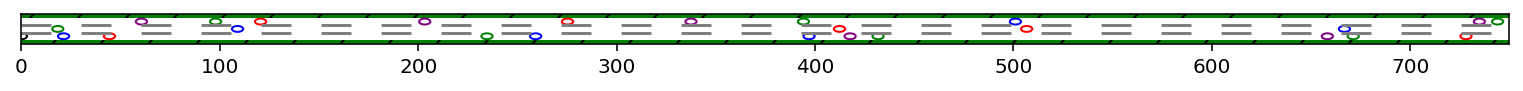

In [13]:
amb_x0 = amb_x0.reshape(6,1)
all_other_x0 = [x.reshape(6,1) for x in all_other_x0]

cmplot.plot_multiple_cars(0, world, amb_MPC, amb_x0, all_other_x0, None, 'Ellipse', None, None, None, [0, 750])
plt.show()

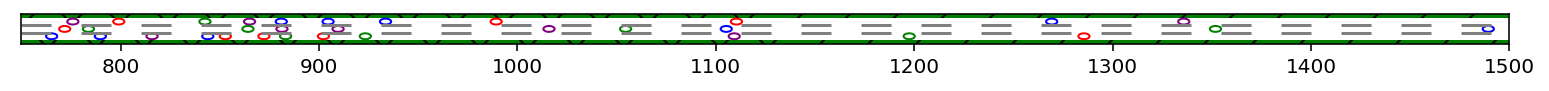

In [14]:
amb_x0 = amb_x0.reshape(6,1)
all_other_x0 = [x.reshape(6,1) for x in all_other_x0]

cmplot.plot_multiple_cars(0, world, amb_MPC, amb_x0, all_other_x0, None, 'Ellipse', None, None, None, [750, 1500])
plt.show()

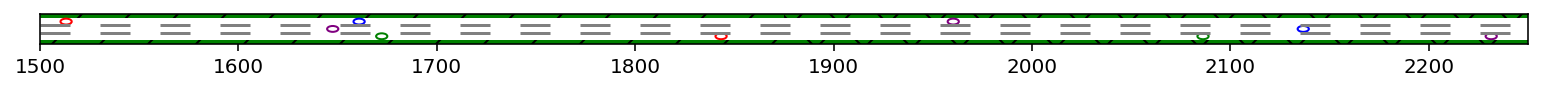

In [15]:
amb_x0 = amb_x0.reshape(6,1)
all_other_x0 = [x.reshape(6,1) for x in all_other_x0]

cmplot.plot_multiple_cars(0, world, amb_MPC, amb_x0, all_other_x0, None, 'Ellipse', None, None, None, [1500, 1500+750])
plt.show()

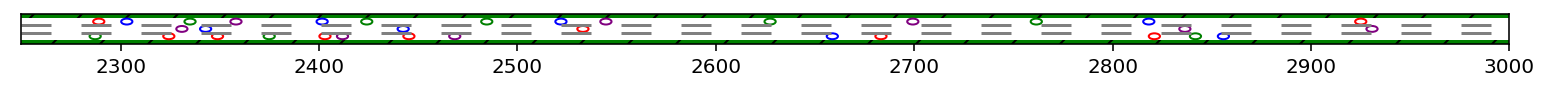

In [16]:
amb_x0 = amb_x0.reshape(6,1)
all_other_x0 = [x.reshape(6,1) for x in all_other_x0]

cmplot.plot_multiple_cars(0, world, amb_MPC, amb_x0, all_other_x0, None, 'Ellipse', None, None, None, [2250, 3000])
plt.show()

In [60]:
max(all_other_x0,key=lambda x: x[0])

array([2930.74756,    3.7    ,    0.     ,    0.     ,   11.06325,
          0.     ])

In [2]:
load_log_dir = "/home/nbuckman/mpc_results/d1dh-0h64-20200918-160320/"
with open(load_log_dir + "params.json",'rb') as fp:
    params = json.load(fp)

In [3]:
params["svo_theta"] = np.pi/3.0
no_grass = False
random_lane = False
x_variance = 1.0
list_of_positions = None
params["n_lanes"] = 2
params["n_other"] = 100

In [4]:
world = tw.TrafficWorld(params["n_lanes"], 0, 999999)

In [5]:
params["car_density"] = [5000, 
params["random_svo"] = True

In [6]:
# This should be replaced with random placement
MAX_VELOCITY = 25 * 0.447 # m/s
VEHICLE_LENGTH = 4.5 #m
time_duration_s = (params["n_other"] * 3600.0 / params["car_density"] ) * 5 # amount of time to generate traffic
initial_vehicle_positions = helper.poission_positions(params["car_density"], int(time_duration_s), params["n_lanes"] , MAX_VELOCITY, VEHICLE_LENGTH)
position_list = initial_vehicle_positions[:params["n_other"]]
if params['random_svo']:
    list_of_svo = [np.random.choice([0, np.pi/4.0, np.pi/2.01]) for i in range(params["n_other"])]
else:
    list_of_svo = None
amb_MPC, amb_x0, all_other_MPC, all_other_x0 = helper.initialize_cars_from_positions(params["N"], params["dt"], world, params["svo_theta"], 
                                                            True, 
                                                            position_list, list_of_svo)    

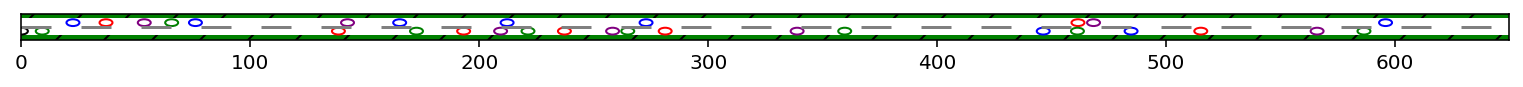

In [9]:
amb_x0 = amb_x0.reshape(6,1)
all_other_x0 = [x.reshape(6,1) for x in all_other_x0]

cmplot.plot_multiple_cars(0, world, amb_MPC, amb_x0, all_other_x0, None, 'Ellipse', None, None, None, [0, 650])
plt.show()

In [92]:
len(all_other_x0)

100

In [34]:
cars_per_hour = 5000
total_seconds = time_duration_s
cars_per_second = cars_per_hour / 3600.0
dt = 0.20
cars_per_dt = cars_per_second * dt
rng = np.random.default_rng()
n_cars_per_second = rng.poisson(cars_per_second, total_seconds)
total_dt = int(total_seconds / dt)
n_cars_per_dt = rng.poisson(cars_per_dt, total_dt)


vehicle_x_distance = [[(rng.uniform(0.95, 1.0)*average_velocity)*(s + rng.uniform(0,1))]*n_cars_per_second[s] for s in range(len(n_cars_per_second))]
vehicle_x_distance = [[(rng.uniform(0.95, 1.0)*average_velocity)*(s*dt)]*n_cars_per_dt[s] for s in range(len(n_cars_per_second))]


all_vehicle_positions = []

### Random place vehicles in the lanes
for s in range(len(vehicle_x_distance)):
    if len(vehicle_x_distance[s]) == 0:
        continue
    else:
        for j in range(len(vehicle_x_distance[s])):
            all_vehicle_positions += [(rng.integers(0, n_lanes), vehicle_x_distance[s][j])]

# Remove cars that would have collided
prev_car_lane = -9999 * np.ones((n_lanes,1))
prev_car_lane[0] = 0.0
initial_vehicle_positions = []
for (lane, x) in all_vehicle_positions:
    if x > prev_car_lane[lane] + 1.4*car_length:
        initial_vehicle_positions += [(lane, float(x))]
        prev_car_lane[lane] = x


TypeError: 'float' object cannot be interpreted as an integer

In [8]:
import numpy as np


In [9]:
cars_per_hour = 500 #cars per hour
cars_per_second = cars_per_hour / 3600.0
total_minutes = 15
total_seconds = total_minutes * 60
print(cars_per_second)

0.1388888888888889


In [10]:
average_velocity = all_other_x0[4][4]

In [93]:
def poission_positions(cars_per_hour, total_seconds, n_lanes, average_velocity, car_length):
    cars_per_second = cars_per_hour / 3600.0
    rng = np.random.default_rng()
    n_cars_per_second = rng.poisson(cars_per_second, total_seconds)
    
    vehicle_x_distance = [[average_velocity*(s + rng.uniform(0,1))]*n_cars_per_second[s] for s in range(len(n_cars_per_second))]
    
    all_vehicle_positions = []
    for s in range(len(vehicle_x_distance)):
        if len(vehicle_x_distance[s]) == 0:
            continue
        else:
            for j in range(len(vehicle_x_distance[s])):
                all_vehicle_positions += [(rng.integers(0, n_lanes), vehicle_x_distance[s][j])]

#     all_vehicle_positions = [(x, rng.integers(0,params["n_lanes"])) for x in all_vehicle_distances]

    # Remove cars that would have collided
    prev_car_lane = -9999 * np.ones(n_lanes)
    prev_car_lane[0] = 0.0
    initial_vehicle_positions = []
    for (lane, x) in all_vehicle_positions:
        if x > prev_car_lane[lane] + 1.1*car_length:
            initial_vehicle_positions += [(lane, float(x))]
            prev_car_lane[lane] = x

    return initial_vehicle_positions
    # counter = 0
    # for x in all_vehicle_distances:
    #     if counter == 0:
    #         lane = 0
    #     elif x > (all_vehicle_positions[counter - 1][0] + 1.1*amb_MPC.L):
    #         # Vehicle is sufficiently far away, place in lane 0
    #         lane = rng.integers(0, 2)
    #     else:
    #         lane = 1 - all_vehicle_positions[counter-1][1]
    #     all_vehicle_positions += [(x, lane)]
    #     counter += 1

In [104]:
params["n_lanes"] = 2
world = tw.TrafficWorld(params["n_lanes"], 0, 999999)

In [105]:
initial_vehicle_positions = poission_positions(3000, 5 * 60, params["n_lanes"] , all_other_x0[0][4], all_other_MPC[0].L)
amb_MPC, x0_amb, all_other_MPC, all_other_x0 = helper.initialize_cars_from_positions(params["N"], params["dt"], world, params["svo_theta"], 
                                                               no_grass, 
                                                               initial_vehicle_positions)

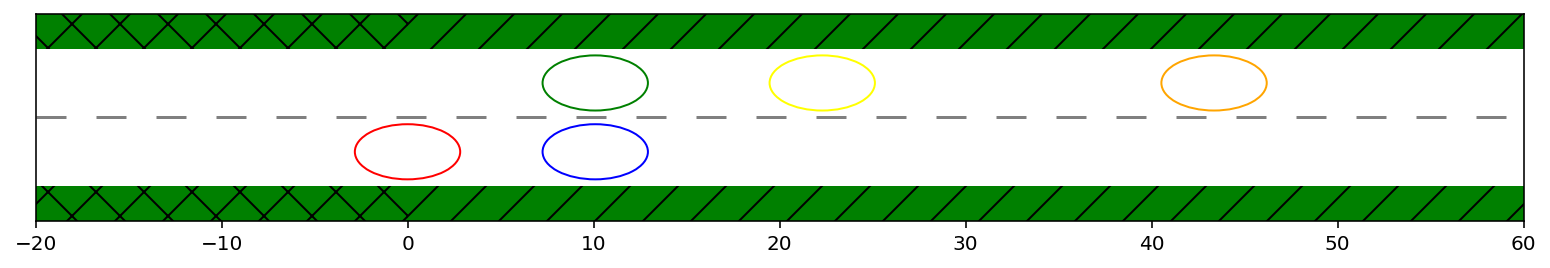

In [106]:
x0_amb = x0_amb.reshape(6,1)
all_other_x0 = [x.reshape(6,1) for x in all_other_x0]

cmplot.plot_multiple_cars(0, world, amb_MPC, x0_amb, all_other_x0, None)
plt.show()

In [107]:
len(all_other_x0)

195

In [108]:
3000 / 60 * 5

250.0